In [1]:
import os
from glob import glob
import numpy as np
from tqdm import tqdm

from PIL import Image

# skimage
from skimage import io, color
import skimage.transform as sktrsfm
from sklearn.metrics import precision_score, recall_score

# Pytorch
import torch
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms

import utils_pnet as utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from random import randrange

In [2]:
img_path = '/home/ubuntu/db_proc/db/images'
anno_path = '/home/ubuntu/db_proc/db/annotations'
valid_percent=0.2,
resize_shape=(12,12)

In [3]:
scale = resize_shape[0] / 400 # assuming that original image size is 400x400

tidx = 20

file_names = sorted(glob(os.path.join(img_path, '*.jpg')))[:tidx]
anno_names = sorted(glob(os.path.join(anno_path, '*.npy')))
anno_names.extend([''] * (len(file_names) - len(anno_names)))
anno_names = anno_names[:tidx]

imgs, b_probs, b_boxes, f_probs, f_boxes = [], [], [], [], []

In [4]:

def bbox_intersect(a, b):
    # get the intersection of bounding boxes a, b
    return np.array([max(a[0],b[0]), max(a[1],b[1]), min(a[2],b[2]), min(a[3],b[3])], dtype='int32')

def valid_bbox(a):
    if a[0] > a[2] or a[1] > a[3]:
        return False
    return True

def get_iou(a, b, eps=1e-5):
    
    x1, y1, x2, y2 = bbox_intersect(a, b)
    """
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])
    """
    
    width = (x2 - x1)
    height = (y2 - y1)

    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    iou = area_overlap / (area_combined+eps)
    return iou

def upd_bbox(oboxa, niba, t_size):
    # updates the coordinates of a bounding box when the original image is cropped
    # assumes that nib is a square bbox
    obox, nib = oboxa.copy(), niba.copy()
    scl = t_size / (nib[2] - nib[0])
    obox = bbox_intersect(obox, nib)
    #obox[0] = max(obox[0], nib[0])
    #obox[1] = max(obox[1], nib[1])
    #obox[2] = min(obox[2], nib[2])
    #obox[3] = min(obox[3], nib[3])
    #assert ((obox[0] < obox[2]) and (obox[1]<obox[3]))
    assert valid_bbox(obox)
    obox[0] -= nib[0]
    obox[1] -= nib[1]
    obox[2] -= nib[0]
    obox[3] -= nib[1]
    return obox * scl # scale the coordinates

original image: 0
o_fb: [ 75   0 267 196]


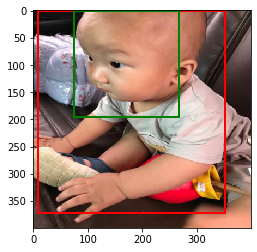

cidx: 0


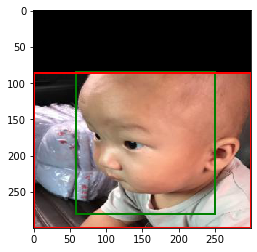

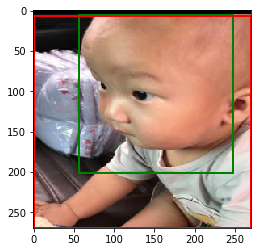

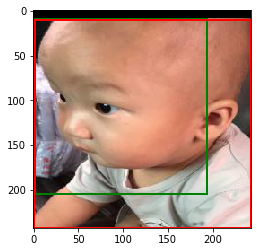

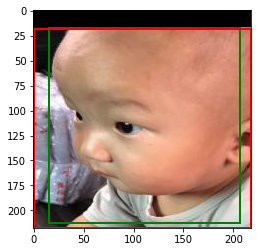

original image: 1
o_fb: [129  39 254 203]


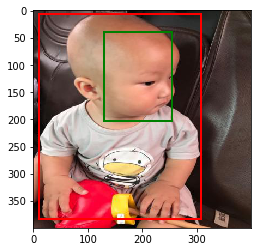

cidx: 1


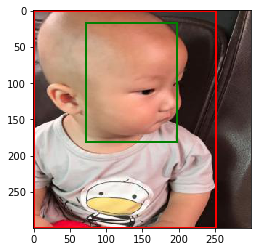

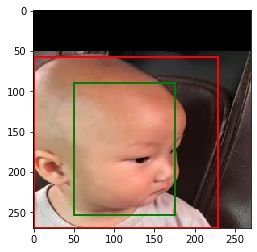

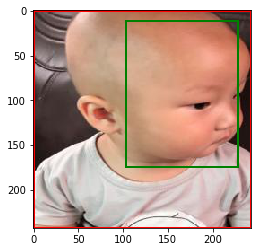

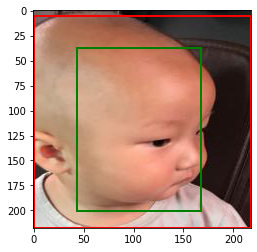

original image: 2
o_fb: [133  60 263 205]


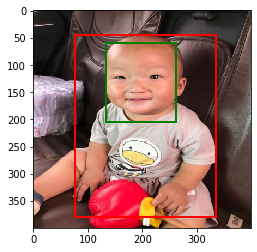

cidx: 2


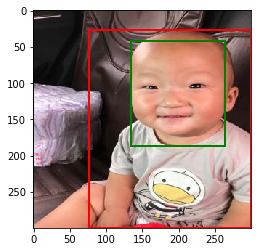

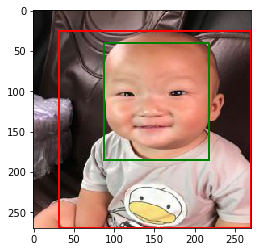

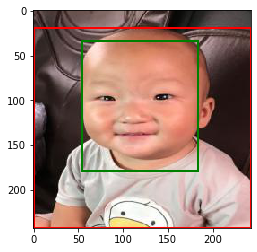

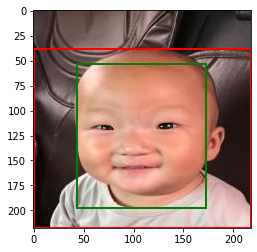

original image: 3
o_fb: [0 0 0 0]


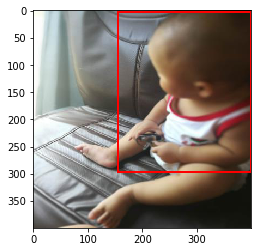

cidx: 3
original image: 4
o_fb: [0 0 0 0]


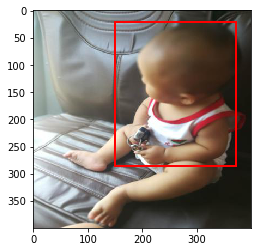

cidx: 4
original image: 5
o_fb: [0 0 0 0]


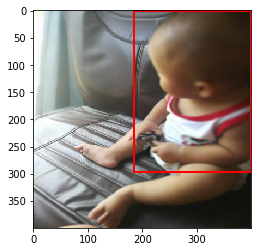

cidx: 5
original image: 6
o_fb: [0 0 0 0]


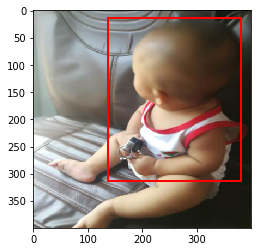

cidx: 6
original image: 7
o_fb: [0 0 0 0]


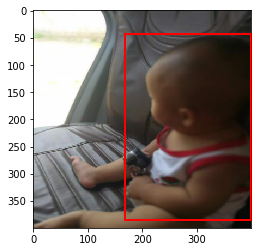

cidx: 7
original image: 8
o_fb: [0 0 0 0]


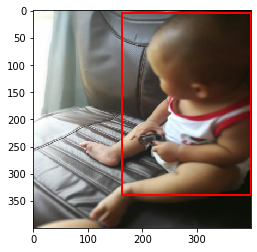

cidx: 8
original image: 9
o_fb: [0 0 0 0]


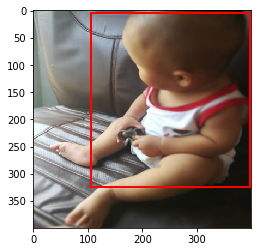

cidx: 9
original image: 10
o_fb: [0 0 0 0]


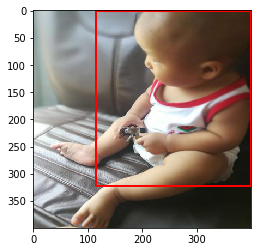

cidx: 10
original image: 11
o_fb: [0 0 0 0]


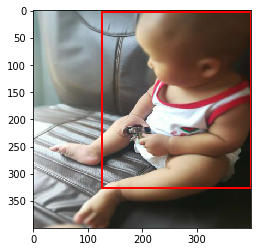

cidx: 11
original image: 12
o_fb: [0 0 0 0]


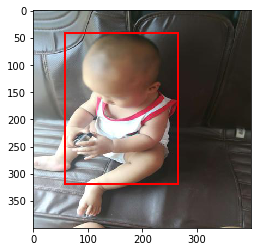

cidx: 12
original image: 13
o_fb: [130  83 252 215]


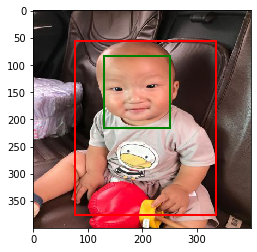

cidx: 13


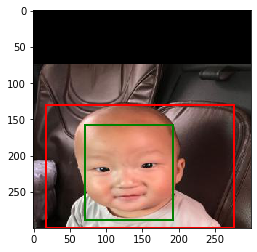

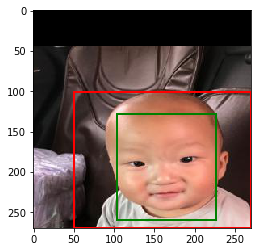

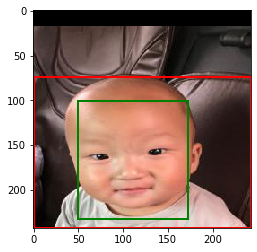

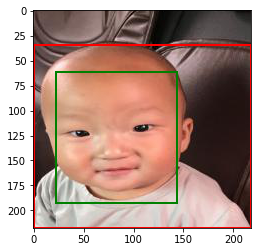

original image: 14
o_fb: [0 0 0 0]


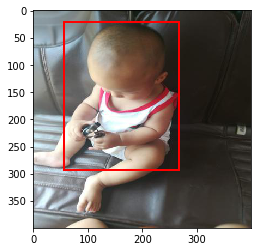

cidx: 14
original image: 15
o_fb: [0 0 0 0]


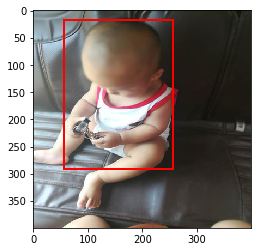

cidx: 15
original image: 16
o_fb: [0 0 0 0]


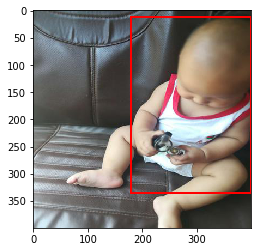

cidx: 16
original image: 17
o_fb: [0 0 0 0]


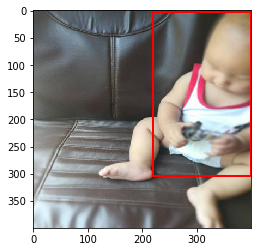

cidx: 17
original image: 18
o_fb: [257  50 355 164]


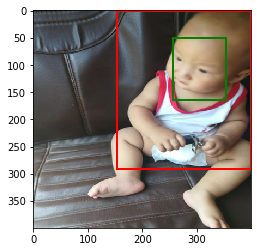

cidx: 18


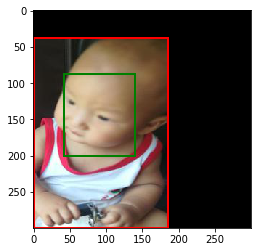

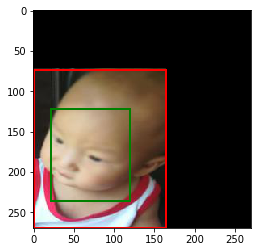

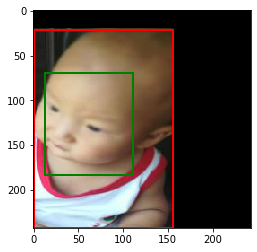

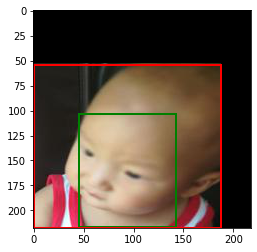

original image: 19
o_fb: [232  50 331 169]


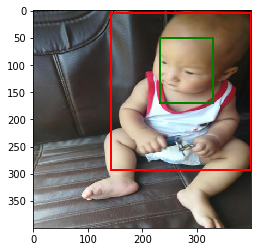

cidx: 19


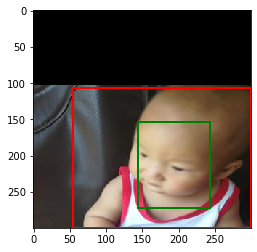

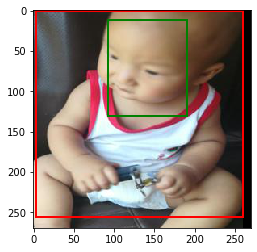

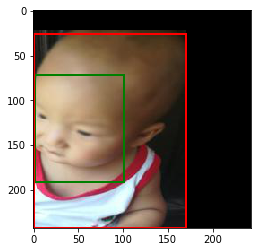

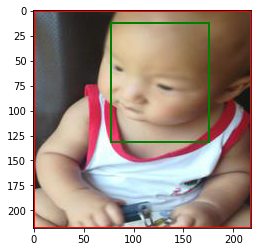

In [5]:
cidx = -1
for cur_file, cur_anno in zip(file_names, anno_names):
    cidx += 1
    img = io.imread(cur_file)

    if img.shape[-1] == 1:
        img = color.grey2rgb(img)

    age = os.path.splitext(os.path.basename(cur_file))[0].split('_')[0]

    if age == 'n': # no child in image
        b_probs.append(np.array([0, 1], dtype='float32'))
        b_boxes.append(np.array([0,0,0,0], dtype='int32')) 
        f_probs.append(np.array([0, 1], dtype='float32'))
        f_boxes.append(np.array([0,0,0,0], dtype='int32'))
    else:
        b_probs.append(np.array([1, 0], dtype='float32'))
        o = np.load(cur_anno)
        o_bb, o_fb = o[0], o[1]
        b_boxes.append(np.array([int(round(k*scale)) for k in o_bb], dtype='int32'))

        if (o_fb == np.array([0,0,0,0])).all():  # no face
            f_probs.append(np.array([0, 1], dtype='float32'))
        else:
            f_probs.append(np.array([1, 0], dtype='float32'))
        f_boxes.append(np.array([int(round(k*scale)) for k in o_fb], dtype='int32'))

    img = torchvision.transforms.ToPILImage()(img.astype(np.uint8))
    imgs.append(img.resize(resize_shape, resample=Image.LANCZOS))
    
    print("original image: {}".format(cidx))
    print("o_fb: {}".format(o_fb))
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    rect = patches.Rectangle((o_bb[0],o_bb[1]),o_bb[2]-o_bb[0],o_bb[3]-o_bb[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    rect = patches.Rectangle((o_fb[0],o_fb[1]),o_fb[2]-o_fb[0],o_fb[3]-o_fb[1],linewidth=2,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    
    plt.show()
    
    # generate additional negative samples
    
    ct_size = 100

    while ct_size >= 12:
        mmax = 400 - ct_size
        for i in range(0, 1):
            cx, cy = 0, 0
            while True:
                cx, cy = randrange(mmax), randrange(mmax)
                nbox = [cx, cy, cx+ct_size, cy+ct_size]
                if (get_iou(nbox, o_bb) < 0.10) and (get_iou(nbox, o_fb) < 0.05):
                    break

            imgs.append(img.crop(nbox).resize(resize_shape, resample=Image.LANCZOS))
            b_probs.append(np.array([0, 1], dtype='float32'))
            b_boxes.append(np.array([0,0,0,0], dtype='int32')) 
            f_probs.append(np.array([0, 1], dtype='float32'))
            f_boxes.append(np.array([0,0,0,0], dtype='int32'))

        ct_size = int(ct_size * 0.709)
    
    if age == 'n':
        continue
    
    # generate positive face samples
    print("cidx: " + str(cidx))
    if (o_fb == np.array([0,0,0,0])).all():  # no face
        continue

    ct_size = 300

    while ct_size >= 200:
        
        lrx = o_fb[2] - ct_size
        lry = o_fb[3] - ct_size

        for i in range(0, 1):
            cx, cy, nbox = 0, 0, []

            trycnt, success = 0, False

            cx, cy = randrange(lrx, o_fb[0]), randrange(lry, o_fb[1])
            nbox = [cx, cy, cx+ct_size, cy+ct_size]
            f_probs.append(np.array([1, 0], dtype='float32'))

            imgs.append(img.crop(nbox).resize(resize_shape, resample=Image.LANCZOS))
            f_boxes.append(upd_bbox(o_fb, nbox, resize_shape[0]))

            # add partial body annotation if applicable

            nbb = bbox_intersect(o_bb, nbox)

            if valid_bbox(nbb):
                nbb_iou = get_iou(nbb, o_bb)

                if nbb_iou < 0.35: # low confidence partial body
                    b_probs.append(np.array([0.5, 0], dtype='float32'))

                elif 0.35 <= nbb_iou < 0.5: # mid confidence partial body
                    b_probs.append(np.array([0.8, 1], dtype='float32'))

                else: # pretty much full-body
                    b_probs.append(np.array([0.99, 1], dtype='float32'))

                b_boxes.append(upd_bbox(nbb, nbox, resize_shape[0]))
            else:
                b_probs.append(np.array([0, 1], dtype='float32'))
                b_boxes.append(np.array([0,0,0,0], dtype='int32'))

            fig,ax = plt.subplots(1)

            tnb = upd_bbox(o_fb, nbox, nbox[2]-nbox[0])
            rect = patches.Rectangle((tnb[0],tnb[1]),tnb[2]-tnb[0],tnb[3]-tnb[1],linewidth=2,edgecolor='g',facecolor='none')
            ax.add_patch(rect)

            tnb = upd_bbox(nbb, nbox, nbox[2]-nbox[0])
            rect = patches.Rectangle((tnb[0],tnb[1]),tnb[2]-tnb[0],tnb[3]-tnb[1],linewidth=2,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

            ax.imshow(img.crop(nbox))
            plt.show()
            
        ct_size = int(ct_size * 0.9)
    
    
